### 1. ResNet 모델 정의

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models

# ResNet 모델 정의
model_ResNet = models.resnet18(pretrained=False, num_classes=10)

c:\Users\MSI\.conda\envs\sesac_gpu_env310_python=3.10\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MSI\.conda\envs\sesac_gpu_env310_python=3.10\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


### 2. 데이터셋 준비

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import numpy as np

# 데이터셋 준비
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 전체 train 데이터셋
trainset_full = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)

# 이중에서 1퍼센트만 사용해보기, 
num_train = len(trainset_full)
indices = list(range(num_train))
np.random.shuffle(indices) # 랜덤 선택
split = int(np.floor(0.01 * num_train))
train_idx = indices[:split]

# train 데이터셋
trainset = Subset(trainset_full, train_idx)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

# validation 데이터셋
# CIFAR-10 검증 데이터셋 로드
valset_full = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

# 이중에서 1퍼센트만 사용해보기
num_val = len(valset_full)
val_indices = list(range(num_val))
np.random.shuffle(val_indices) # 랜덤 선택
val_split = int(np.floor(0.01 * num_val))  # 예: 전체 데이터셋의 10%만 사용
val_idx = val_indices[:val_split]

# val 데이터셋
valset = Subset(valset_full, val_idx)
val_loader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=2)



# test 데이터셋
testset_full = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform)
testset = Subset(testset_full, val_idx)

testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### 3. 손실 함수와 옵티마이저 정의

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ResNet.parameters(), lr=0.001)

### 4. 학습 함수 정의

In [6]:
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # 모델을 학습 모드로 설정
        model.train()
        running_loss = 0.0
        # 학습 데이터에 대한 반복
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # 그라디언트 초기화
            outputs = model(inputs)  # 모델을 통한 예측
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()  # 역전파
            optimizer.step()  # 최적화 단계

            running_loss += loss.item()

        # 에포크의 평균 학습 손실 계산
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f'Epoch [{epoch + 1}/{epochs}] - Training loss: {epoch_loss:.3f}')

        # 검증 과정
        model.eval()  # 모델을 평가 모드로 설정
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

        # 에포크의 평균 검증 손실 계산
        epoch_val_loss = running_val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)
        print(f'Epoch [{epoch + 1}/{epochs}] - Validation loss: {epoch_val_loss:.3f}')

    return train_losses, val_losses

### 5. 평가 함수 정의

In [7]:
import torchmetrics

def evaluate(model, loader):
    model.eval()
    accuracy_metric = torchmetrics.Accuracy(task='multiclass', num_classes=10, average='macro') 
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model(images)
            # 정확도 업데이트
            accuracy_metric.update(outputs, labels)
    accuracy = accuracy_metric.compute()  # 정확도 계산
    print(f'테스트 이미지 정확도 계산: {accuracy.item() * 100:.2f}%')
    return accuracy.item()


### 6. 모델 학습

In [8]:
history = train_and_validate(model_ResNet, trainloader, val_loader, optimizer, criterion, epochs=10)

Epoch [1/10] - Training loss: 2.344
Epoch [1/10] - Validation loss: 2.293
Epoch [2/10] - Training loss: 1.476
Epoch [2/10] - Validation loss: 2.332
Epoch [3/10] - Training loss: 0.730
Epoch [3/10] - Validation loss: 3.154
Epoch [4/10] - Training loss: 0.334
Epoch [4/10] - Validation loss: 3.591
Epoch [5/10] - Training loss: 0.179
Epoch [5/10] - Validation loss: 3.108
Epoch [6/10] - Training loss: 0.080
Epoch [6/10] - Validation loss: 2.798
Epoch [7/10] - Training loss: 0.047
Epoch [7/10] - Validation loss: 3.090
Epoch [8/10] - Training loss: 0.046
Epoch [8/10] - Validation loss: 3.244
Epoch [9/10] - Training loss: 0.047
Epoch [9/10] - Validation loss: 3.237
Epoch [10/10] - Training loss: 0.035
Epoch [10/10] - Validation loss: 2.970


### 7. 학습 과정 시각화 해보기

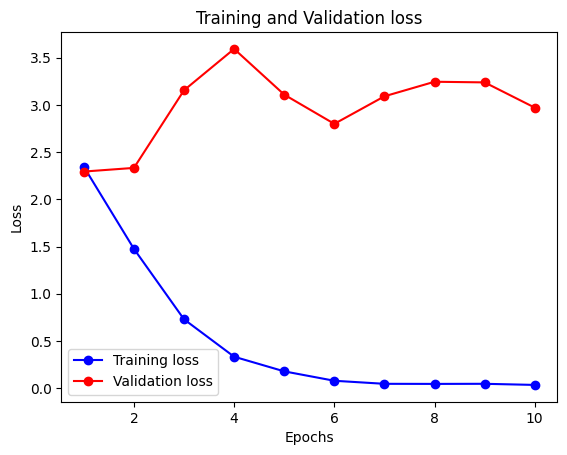

In [9]:
import matplotlib.pyplot as plt

# train_and_validate 함수로부터 손실 기록 받기
train_losses, val_losses = history

# 에포크 번호를 기준으로 그래프를 그립니다.
epochs = range(1, len(train_losses) + 1)

# 학습 및 검증 손실 그래프 그리기
plt.plot(epochs, train_losses, 'bo-', label='Training loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 8. 모델 평가 해보기

In [10]:
evaluate(model_ResNet, testloader)

테스트 이미지 정확도 계산: 28.28%


0.28280162811279297